# Валидация расчета длительностей раундов

В этом ноутбуке найдем и сравним оценки длительностей раундов при заданной вероятности битовой ошибки (BER) с помощью метода Монте-Карло и аналитической модели, построенной на урновой схеме.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from rfidam.inventory import RoundModel, SlotModel, estimate_rounds_props, SlotValues
from rfidam.protocol import Protocol, LinkProps
from rfidam.utils import bcolors, get_err, fmt_err, highlight, pluralize
from rfidlib.protocol.symbols import TagEncoding, DR

from tabulate import tabulate
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Определим вспомогательные методы для однотипной подстветки таблиц и форматирования строк.

In [3]:
def fmt_header(s):
    return highlight(s, bcolors.OKBLUE)

def fmt_delim(s):
    return highlight(s, bcolors.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

## Параметры модели

Определим два сценария идентификации меток:

- идентификация по EPCID
- идентификация по TID и EPCID

В обоих случаях будем использовать идентичные настройки протокола:

- `Tari = 12.5us`
- `RTcal = 37.5us`
- `TRcal = 50us`
- `DR = 64/3`
- `TRext = 0`
- `Q = 4`
- `M = 2`

Также будем считать, что длина EPCID равна 12 байтам, а TID - 8 байтам (4 словам).

In [4]:
PROTOCOL_SETTINGS = {
    'tari': 12.5e-6,
    'rtcal': 37.5e-6,
    'trcal': 50e-6,
    'm': TagEncoding.M2,
    'dr': DR.DR_643,
    'trext': False,
    'q': 4,
    't_off': 0.1,
    'n_epcid_bytes': 12,
    'n_data_words': 4
}

LINK_PROPS = {
    'epcid': LinkProps(**PROTOCOL_SETTINGS, use_tid=False),
    'tid': LinkProps(**PROTOCOL_SETTINGS, use_tid=True)
}

PROTOCOLS = {key: Protocol(LINK_PROPS[key]) for key in LINK_PROPS}

Число меток будем брать из множества $N = 0, 1, 2, 3, 4, 10, 20$.

In [5]:
N_TAGS = np.arange(21)
BER = [.001, .005, .01, .02]

## Вычисление параметров раундов методом Монте-Карло

Рассчитаем длины слотов и раундов методом Монте-Карло. Для этого будем моделировать процесс идентификации меток, собирать длительности слотов без ответов меток, слотов с попытками ответа одной метки и слотов с коллизиями.

In [22]:
# We will store values for each protocol in matrices,
# where rows correspond to different BER values and columns - number of tags:

ESTIMATED_ROUND_DURATIONS = {key: [] for key in PROTOCOLS}
ESTIMATED_SLOTS_DURATIONS = {key: [] for key in PROTOCOLS}
ESTIMATED_SLOTS_COUNTS = {key: [] for key in PROTOCOLS}

TQDM_PROTOCOLS = tqdm(PROTOCOLS)

for protocol_name in TQDM_PROTOCOLS:
    
    TQDM_PROTOCOLS.set_description(protocol_name)
    TQDM_BER = tqdm(BER, leave=False)
    protocol = PROTOCOLS[protocol_name]

    for ber in TQDM_BER:
        
        TQDM_BER.set_description(f'BER={ber}')
        estimated_round_durations = []
        estimated_slots_durations = []
        estimated_slots_counts = []
        TQDM_TAGS = tqdm(N_TAGS, leave=False)
        
        for n_tags in TQDM_TAGS:
            TQDM_TAGS.set_description(f'{n_tags} tags')
            
            # Run Monte-Carlo:
            round_duration, slots_durations, slots_counts = \
                estimate_rounds_props(protocol, n_tags, ber, n_iters=range(10000))
            
            estimated_round_durations.append(round_duration)
            estimated_slots_durations.append(slots_durations)
            estimated_slots_counts.append(slots_counts)
        
        # Store results:
        ESTIMATED_ROUND_DURATIONS[protocol_name].append(estimated_round_durations)
        ESTIMATED_SLOTS_DURATIONS[protocol_name].append(estimated_slots_durations)
        ESTIMATED_SLOTS_COUNTS[protocol_name].append(estimated_slots_counts)

## Вычисление параметров раундов с помощью аналитической модели

Теперь вычислим длительности раундов и слотов с помощью аналитической модели. Эта модель использует урновую схему (см. `rfidam.baskets`) для расчета среднего количества пустых слотов, слотов с одним ответом и слотов с коллизиями.

In [25]:
# As above, we store models in dictionaries with the same keys sets as protocols.
# At each key, we store a matrix, in which:
# - rows correspond to BER values
# - columns correspond to different numbers of tags
ROUND_MODELS = {key: [] for key in PROTOCOLS}

# Also store round durations separately.
# We do so, since `round_durations` property is cached, so calling it will run estimation.
ANALYTIC_ROUND_DURATIONS = {key: [] for key in PROTOCOLS}

TQDM_PROTOCOLS = tqdm(PROTOCOLS)
for protocol_name in TQDM_PROTOCOLS:
    
    TQDM_PROTOCOLS.set_description(protocol_name)
    TQDM_BERS = tqdm(BER, leave=False)
    protocol = PROTOCOLS[protocol_name]

    for ber in TQDM_BERS:
        
        TQDM_BERS.set_description(f'BER={ber}')    
        models = []
        round_durations = []
        
        for n_tags in N_TAGS:
            # Build and store the model:
            model = RoundModel(protocol, n_tags, ber)
            models.append(model)
            round_durations.append(model.round_duration)
        
        # Store models for the given BER:
        ROUND_MODELS[protocol_name].append(models)
        ANALYTIC_ROUND_DURATIONS[protocol_name].append(round_durations)

## Сравнение длин слотов

Сначала сравним длительности слотов, рассчитанные из аналитической модели и методом Монте-Карло.

In [26]:
# Compare slots durations estimated with Monte-Carlo method and analytic approach
BER_INDEX = -2
PROTOCOL_NAME = 'tid'

rows = []
for i, n_tags in enumerate(N_TAGS):
    rounds_model = ROUND_MODELS[PROTOCOL_NAME][BER_INDEX][i]
    estimated_round_duration = ESTIMATED_ROUND_DURATIONS[PROTOCOL_NAME][BER_INDEX][i]
    estiamted_slots_durations = ESTIMATED_SLOTS_DURATIONS[PROTOCOL_NAME][BER_INDEX][i]
    estimated_slots_counts = ESTIMATED_SLOTS_COUNTS[PROTOCOL_NAME][BER_INDEX][i]

    # Compute slot probabilities:
    estimated_slots_probs = SlotValues(
        empty=(estimated_slots_counts.empty / protocol.props.n_slots),
        collided=(estimated_slots_counts.collided / protocol.props.n_slots),
        reply=(estimated_slots_counts.reply / protocol.props.n_slots))
    
    # Build table rows:
    value_rows = [
        [fmt_header('round duration'), rounds_model.round_duration, estimated_round_duration],
        [fmt_header('empty slot duration'), rounds_model.slots.durations.empty, estiamted_slots_durations.empty],
        [fmt_header('collided slot duration'), rounds_model.slots.durations.collided, estiamted_slots_durations.collided],
        [fmt_header('reply slot duration'), rounds_model.slots.durations.reply, estiamted_slots_durations.reply],
        [fmt_header('empty slot probability'), rounds_model.slots.probs.empty, estimated_slots_probs.empty],
        [fmt_header('collided slot probability'), rounds_model.slots.probs.collided, estimated_slots_probs.collided],
        [fmt_header('reply slot probability'), rounds_model.slots.probs.reply, estimated_slots_probs.reply],
    ]

    # Append errors estimations to each row:
    for row in value_rows:
        row.append(fmt_err(row[-1], row[-2]))
    
    # Add rows to the main table:
    title_row = [fmt_delim(f'{n_tags} tag{pluralize(n_tags)}')] + [''] * 3
    rows.append(title_row)
    rows.extend(value_rows)

headers = [fmt_header(s) for s in ['', 'Analytic', 'Simulation', 'Error']]
print(tabulate(rows, headers=headers))

                           Analytic                Simulation              Error
-------------------------  ----------------------  ----------------------  -------
0 tags
round duration             0.0036375               0.0036375000000000014   0.0000
empty slot duration        7.5e-05                 7.5e-05                 0.0000
collided slot duration     0.00019101562500000002  0.00019101562499999997  0.0000
reply slot duration        0.001668374743740638    nan                     nan
empty slot probability     1.0                     1.0                     0.0000
collided slot probability  0.0                     0.0                     0.0000
reply slot probability     0.0                     0.0                     0.0000
1 tag
round duration             0.0052308747437406385   0.005228900273437501    0.0004
empty slot duration        7.5e-05                 7.5e-05                 0.0000
collided slot duration     0.00019101562500000002  0.00019101562499999997  0.0000
reply 

## Сравнение длительностей раундов

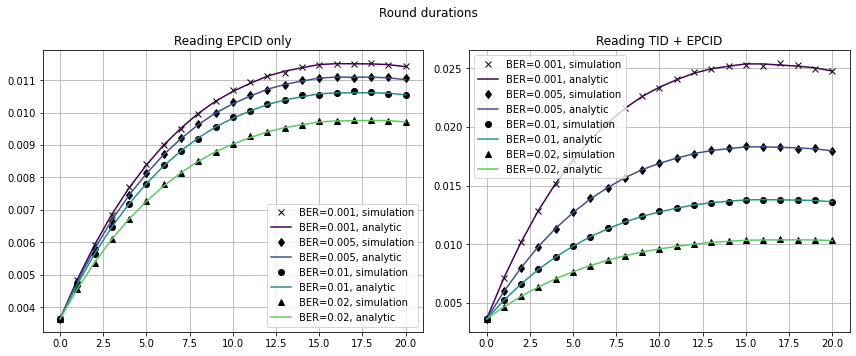

In [27]:
CMAP = plt.get_cmap('viridis')
fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)
MARKERS = ['x', 'd', 'o', "^", 'v']
for i, ber in enumerate(BER):
    color = CMAP(i/len(BER))
    marker = MARKERS[i % len(MARKERS)]
    ax1.plot(N_TAGS, ESTIMATED_ROUND_DURATIONS['epcid'][i], 
             label=f'BER={ber}, simulation', marker=marker, color='black', linestyle="None")
    ax1.plot(N_TAGS, ANALYTIC_ROUND_DURATIONS['epcid'][i], 
             label=f'BER={ber}, analytic', color=color)
    ax2.plot(N_TAGS, ESTIMATED_ROUND_DURATIONS['tid'][i], 
             label=f'BER={ber}, simulation', marker=marker, color='black', linestyle="None")
    ax2.plot(N_TAGS, ANALYTIC_ROUND_DURATIONS['tid'][i], 
             label=f'BER={ber}, analytic', color=color)
ax1.set_title('Reading EPCID only')
ax2.set_title('Reading TID + EPCID')
fig.suptitle('Round durations')
for ax in (ax1, ax2):
    ax.legend()
    ax.grid()
plt.tight_layout()

## Экспериментальный код